In [231]:
import pandas as pd
import pylab as plt
import seaborn as sns
%pylab inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Machine Learning in Python

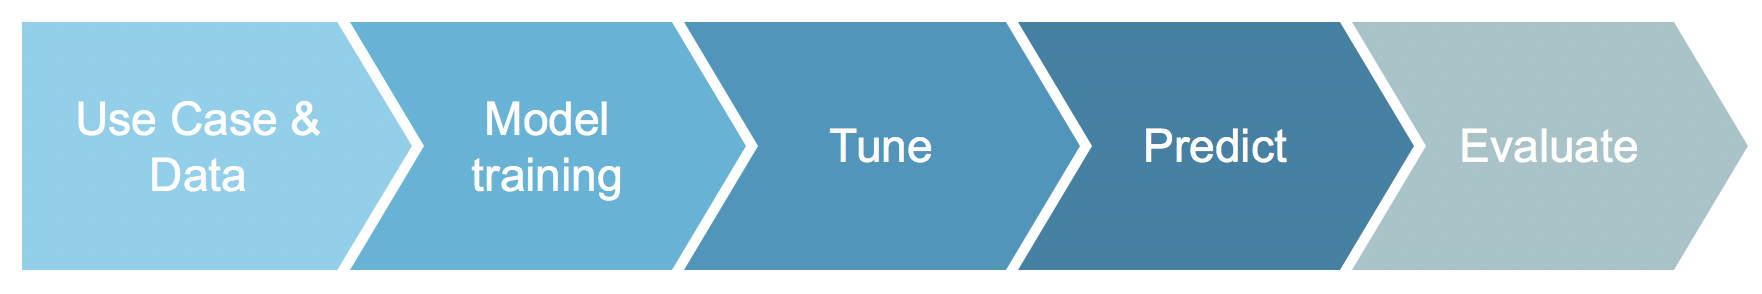

In [207]:
Image('data/5_steps.png', width = 600)

## Worked Example 1: Predicting mode of travel to work

For a workshop in November 2018, participants filled out a survey (56 responses) based on the following fictional scenario:

**A new cohort of 100 staff have just been hired, and will start after Thanksgiving. We need to decide how many bike racks or parking spaces to build for them. To do so, we'll use data on current staff to build a machine learning model. For fun, we'll also predict whether staff prefer classical music or heavy metal.**

#### 1. Load and prepare data

In [306]:
# The data was collected on Google Forms and downloaded as a CSV file.
# We'll load it as a dataframe ('df'), clean up the column names, and take a look.

df = pd.read_csv('data/responses2.csv')

df.columns = ['gender','household_type','state','favorite_food','exercise_regime','mode_of_travel','arrival_time','music_choice','purchase_history','age']
df = df[['gender','household_type','state','favorite_food','exercise_regime','purchase_history','age','music_choice','arrival_time','mode_of_travel']]

df.head()

,gender,household_type,state,favorite_food,exercise_regime,purchase_history,age,music_choice,arrival_time,mode_of_travel
0,Male,I live with my family.,DC,Steak,Keep fit through yoga and jogging.,NaN,NaN,Heavy metal / rock,9:00:00 AM,Walk or bike
1,Female,I live by myself or with housemates.,DC,Mexican,Keep fit through jogging or gym.,Theater tickets,35-44,Classical music,7:30:00 AM,Walk or bike
2,Male,I live by myself or with housemates.,DC,Home cooking,Keep fit through jogging or gym.,Theater tickets,25-34,Classical music,9:30:00 AM,Train
3,Male,I live with my family.,DC,Home cooking,Keep fit through jogging or gym.,"Gardening or home improvement gear, Bluetooth ...",35-44,Classical music,9:00:00 AM,Walk or bike
4,Female,I live by myself or with housemates.,DC,Home cooking,Keep fit through jogging or gym.,"Gardening or home improvement gear, Bluetooth ...",25-34,Classical music,8:30:00 AM,Walk or bike


#### 2. Inspect the data

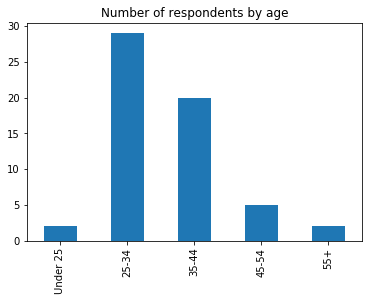

In [307]:
# Our respondents are from a broad set of ages

pd.Series(df.age.value_counts(sort=False),
          index=['Under 25','25-34','35-44','45-54','55+']).plot(kind='bar',title='Number of respondents by age')

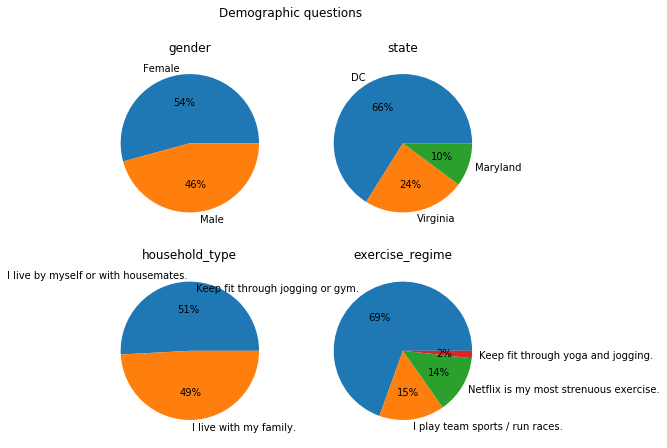

In [308]:
# There are slightly more women than men, and the majority live in DC.

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=[7,7])
pies = ['gender','state','household_type','exercise_regime']

for n,i in enumerate(pies):
    ax = axes.flatten()[n]
    df[i].value_counts().plot(kind='pie',autopct='%1.0f%%',ax=ax)
    ax.set(ylabel='',title=i)

fig.suptitle("Demographic questions");


--> We'll use supervised learning methods, so having a target variable is crucial. We have two target variables. We'll build one model to predict mode of transport, and a second model to predict music choice. The classes are fairly evenly balanced.

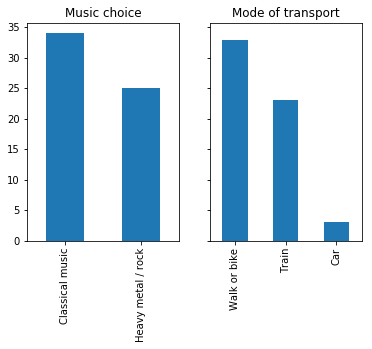

In [309]:
fig,axes = plt.subplots(1,2,sharey=True)
df.mode_of_travel.value_counts().plot(kind='bar',ax=axes[1],title='Mode of transport')
df.music_choice.value_counts().plot(kind='bar',ax=axes[0],title='Music choice');

#### 3. Create a machine-readable set of features
We need to transform the data before our algorithm can work with it:

* For categorical features (eg. State = DC, Maryland or Virginia), transform them into dummy variables.
* This will give us a new column for each possible value, encoded as 0 or 1. (So if you live in DC, you'll be marked '1' in the DC column and '0' in the Virginia and Maryland columns.

In [310]:
# Transform the purchases data from string (eg. 'yoga mat, theater tickets') to a list.  

df.purchase_history = df.purchase_history.astype(str)
df.purchase_history = [cell.split(',') for cell in df.purchase_history]

# Create dummies for purchase history

items = ['Theater tickets','Yoga mat','Bluetooth speaker / headphones',
             'Gardening or home improvement gear',' Presents for my kids']

for item in items:
    df[item] = [item in cell for cell in df.purchase_history]
    df[item] = df[item].map({False:0,True:1})

In [311]:
# Take the mid-point of the age range
df['age'] = df.age.map({'Under 25':20,'25-34':29.5,'35-44':39.5,'45-54':49.5,'55+':60})

In [312]:
# Transform gender, household_type, state, food and exercise to dummies

for feature in ['gender','household_type','state','favorite_food','exercise_regime']:
    dummy_feature = pd.get_dummies(df[feature])
    df = pd.concat([df,dummy_feature], axis=1)

In [313]:
# Map the TRANSPORT and MUSIC_CHOICE columns (our target variables) to 0s/1s

y_transport = df.mode_of_travel.map({'Train':0,'Car':0,'Walk or bike':1})
y_music = df.music_choice.map({'Classical music':0,'Heavy metal / rock':1})

# Note, we're using the following binary values:

# TRANSPORT -- Train or car: 0, Walk or bike, 1
# MUSIC -- Classical: 0, Heavy metal / rock: 1

In [319]:
# In machine learning, the set of predictive features is typically denoted X. The target variable is denoted y.
# This reflects mathematical notation where y = f(X)   [outcome y is a function of features x1 ... xN]

# Here are the feature we'll use:

X = ['Theater tickets', 'Yoga mat', 'Bluetooth speaker / headphones', 'Gardening or home improvement gear',
       ' Presents for my kids', 'age', 'Female', 'Male',
       'I live by myself or with housemates.', 'I live with my family.', 'DC',
       'Maryland', 'Virginia', 'Home cooking', 'Mexican', 'Steak', 'Sushi',
       'Vegetarian', 'I play team sports / run races.',
       'Keep fit through jogging or gym.','Netflix is my most strenuous exercise.']

In [323]:
df.age.fillna(value = df.age.mean(), inplace = True)

In [333]:
df[X].head(2) # Processed set of features:

,Theater tickets,Yoga mat,Bluetooth speaker / headphones,Gardening or home improvement gear,Presents for my kids,age,Female,Male,I live by myself or with housemates.,I live with my family.,...,Maryland,Virginia,Home cooking,Mexican,Steak,Sushi,Vegetarian,I play team sports / run races.,Keep fit through jogging or gym.,Netflix is my most strenuous exercise.
0,0,0,0,0,0,35.396552,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,39.500000,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0


#### 4. Build decision tree model
**4.1 TRANSPORT**

In [334]:
# Split the data into training and test sets. We take 70% of data to train the model, 30% to evaluate it.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[X],y_transport,test_size=0.3)

In [335]:
# check the dataframes are the right size

print("X_train: {} rows, {} columns".format(X_train.shape[0], X_train.shape[1]))
print("y_train: {} rows".format(y_train.shape[0]))
print("X_test: {} rows, {} columns".format(X_test.shape[0], X_test.shape[1]))
print("y_test: {} rows".format(y_test.shape[0]))


X_train: 41 rows, 21 columns
y_train: 41 rows
X_test: 18 rows, 21 columns
y_test: 18 rows


In [337]:
# Instantiate a classifier:

tree = DecisionTreeClassifier(max_depth=3,min_samples_leaf=3)

# Fit it with the training data:

tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
# the .dot file can be pasted into WebGraphViz to produce the tree graphics

export_graphviz(tree_transport, out_file='tree.dot', 
                feature_names = X,
                class_names = ['Train/car','walk/bike'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

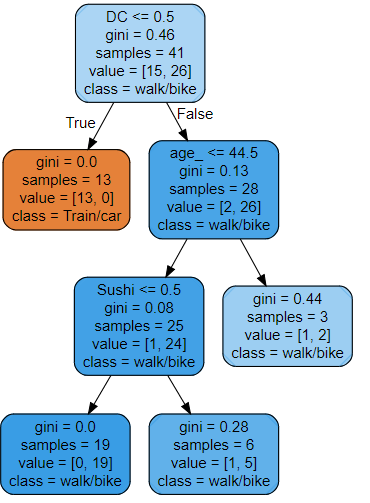

In [340]:
from IPython.display import Image
Image('data/tree1.png')

**4.2 MUSIC TASTE**

In [356]:
X_train_music, X_test_music, y_train_music, y_test_music = train_test_split(df[X],y_music,test_size=0.3)

In [357]:
tree_music = DecisionTreeClassifier(max_depth=3)
tree_music.fit(X_train_music,y_train_music)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
export_graphviz(music_tree, out_file='tree2.dot', 
                feature_names = X,
                class_names = ['Classical','Metal'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

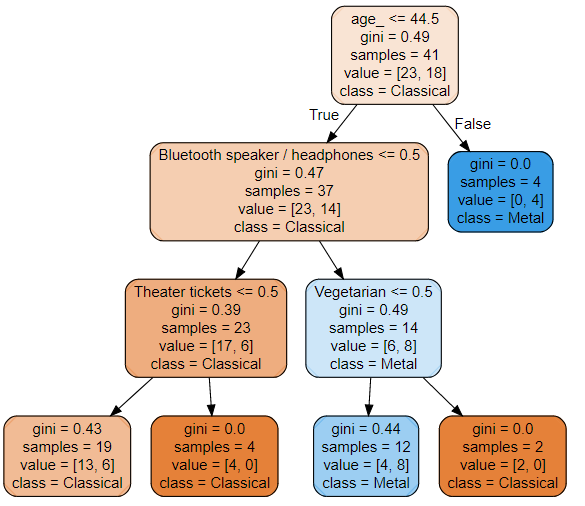

In [345]:
Image('data/tree2.png')

#### 4. Predict against test set, evaluate performance

In [347]:
predictions_transport = tree.predict(X_test)

print("TRANSPORT: First 10 predictions: {}".format(predictions_transport[:10].tolist()))

TRANSPORT: First 10 predictions: [1, 1, 0, 1, 0, 1, 0, 1, 0, 0]


In [350]:
# How many of the predicted value equal the actual values?
n_samples = len(predictions_transport)
n_correct = sum(predictions_transport == y_test)
accuracy = n_correct / n_samples * 100

print("TRANSPORT - We predicted {} right out of {} examples. That's a {:.1f} % accuracy rate.".format(
    n_correct,n_samples,accuracy))

TRANSPORT - We predicted 15 right out of 18 examples. That's a 83.3 % accuracy rate.


In [358]:
# Check accuracy for music

predictions_music = tree_music.predict(X_test_music)

print("MUSIC - We predicted {} right out of {} examples. That's a {:.1f} % accuracy rate.".format(
    sum(predictions_music == y_test_music),n_samples,sum(predictions_music == y_test_music)/n_samples*100))

MUSIC - We predicted 11 right out of 18 examples. That's a 61.1 % accuracy rate.


--> Note that the transport model addresses an easy task, whereas predicting musical taste seems difficult. What could boost the prediction accuracy? Two approaches: get more data to train your models on, or improve the model.

## Worked Example 2: Predict building earthquake damage from Nepal

This is a currently on-going challenge hosted by DrivenData (https://www.drivendata.org/competitions/57/nepal-earthquake/data/).

**Based on aspects of building location and construction, your goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.**

The data was collected through surveys by the Central Bureau of Statistics that work under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

Prediction variable: `damage_grade`:
* 1 represents low damage
* 2 represents a medium amount of damage
* 3 represents almost complete destruction

Selected features:
* `count_floors_pre_eq`: number of floors before the earthquake
* `age`: age of the building in years
* `area`: normalized area of the building footprint
* `foundation type`: the type of foundation used when building
* `has_superstructure_bamboo`: flag variable indicating the superstructure was made of bamboo
* `has_superstructure_rc_engineered`: flag variable indicating the superstructure was made of reinforced concrete

#### 1. Import data, create training and test sets

In [369]:
X = pd.read_csv('data/train_values.csv')
y = pd.read_csv('data/train_labels.csv', usecols = ['damage_grade'])

In [370]:
print("Dataset has {} rows and {} columns.".format(*X.shape))
X.head(2)

Dataset has 260601 rows and 39 columns.


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0


In [371]:
columns_to_make_dummies_from = ['land_surface_condition',
'foundation_type',
'roof_type',
'ground_floor_type',
'other_floor_type',
'position',
'plan_configuration',
'legal_ownership_status']

In [372]:
for column in columns_to_make_dummies_from:
        X.append(pd.get_dummies(X[column]))

X = X.drop(columns = columns_to_make_dummies_from)
X = X.drop(columns = 'building_id')

/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [373]:
# For now, let's make this a binary classification problem

y = pd.Series(y.damage_grade.map({3:1, 2:0, 1:0}))

In [374]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## YOUR ACTION:

1. Conduct exploratory data visualization of this dataset

    \* You may want to answer questions like: (i) what's the distribution of building age, height and floorspace; (ii) how evenly balanced is the outcome variable; (iii) was severe damage a more frequent outcome for some categories of buildings than others?

    \* Try pandas plotting functions (eg .plot(kind = 'xyz') or .hist())


2. Implement a train_test_split


3. Fit a decision tree and a random forest with 10 trees

    \* This requires RandomForestClassifier, specifying the parameter n_estimators for number of trees. Explore the other parameters available.

    \* If fitting the full dataset takes too long, use a subset of the data (eg. 1000 rows).
    
    
4. Predict against the test set and see what accuracy the model achieved.

#### 2. Train model

In [384]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [385]:
rf = RandomForestClassifier(n_estimators = 4)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### 3. Predict against test set, evaluate performance

In [386]:
predictions_tree = tree.predict(X_test)
sum(predictions_tree == y_test) / len(y_test)

# or use the built in .score() method as below

0.7429970376509953

In [387]:
IS_accuracy = rf.score(X_train, y_train)
OS_accuracy = rf.score(X_test, y_test)
print(IS_accuracy, OS_accuracy)

0.9338245075466871 0.7597581004128869


In [236]:
log_reg.score(X_test, y_test.damage_grade)

0.6632898957805713

#### 4. Model tuning

In [261]:
def evaluate_accuracy(model):
    ''' Returns in-sample accuracy, out-of-sample accuracy'''
    return(model.score(X_train, y_train.damage_grade),
          model.score(X_test, y_test.damage_grade))

In [267]:
# Accuracy versus number of trees

IS_accuracy_list = []
OS_accuracy_list = []
n_estimators = np.arange(1, 100, 5)

for i in n_estimators:
    rf = RandomForestClassifier(n_estimators = i)
    rf.fit(X_train,y_train.damage_grade)
    IS_accuracy, OS_accuracy = evaluate_accuracy(rf)
    IS_accuracy_list.append(IS_accuracy)
    OS_accuracy_list.append(OS_accuracy)

Text(0.5, 1.0, 'Accuracy versus number of trees')

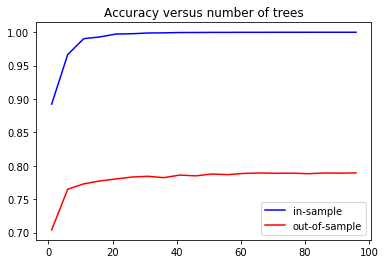

In [268]:
f, ax = plt.subplots()
sns.lineplot(x = n_estimators, y = IS_accuracy_list, color = 'b', ax = ax, label = "in-sample")
sns.lineplot(x = n_estimators, y = OS_accuracy_list, color = 'r', ax = ax, label = "out-of-sample")
plt.title('Accuracy versus number of trees')

In [245]:
n_rows

array([  1000.        ,  29428.57142857,  57857.14285714,  86285.71428571,
       114714.28571429, 143142.85714286, 171571.42857143, 200000.        ])

In [253]:
# Accuracy versus amount of training data
n_rows = np.linspace(1000, X.shape[0], 14).astype(int)
accuracy_list = []
accuracy_list_dummy = []

for n in n_rows:
    rf = RandomForestClassifier(n_estimators = 10)
    dc = DummyClassifier(strategy = 'most_frequent')
    rf.fit(X_train[:n],y_train.damage_grade[:n])
    dc.fit(X_train[:n],y_train.damage_grade[:n])
    preds = rf.predict(X_test)
    preds_dummy = dc.predict(X_test)
    accuracy = sum(preds == y_test.damage_grade) / len(y_test)
    accuracy_list.append(accuracy)
    
    accuracy_dummy = sum(preds_dummy == y_test.damage_grade) / len(y_test)
    accuracy_list_dummy.append(accuracy_dummy)

Text(0.5, 1.0, 'Accuracy versus number of rows')

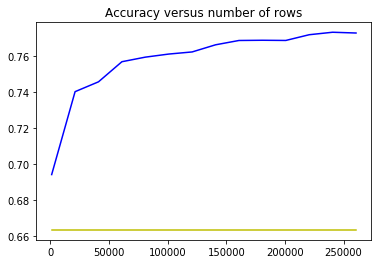

In [254]:
f, ax = plt.subplots()
sns.lineplot(x = n_rows, y = accuracy_list, color = 'b', ax = ax)
sns.lineplot(x = n_rows, y = accuracy_list_dummy, color = 'y', ax = ax)
plt.title('Accuracy versus number of rows')

In [ ]:
5. Sidebar: cross-validation

#### 6. Search for best parameters with GridSearch

In [269]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'n_estimators':np.arange(2,40),'max_depth':[3,4,5,6],'min_samples_leaf':[2,3,4,5]}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),param_grid,cv=5)
grid_search.fit(X_train_transport,y_train_transport)

In [ ]:
print("The best parameters were: {}".format(grid_search.best_params_))
print("The best model classified {} percent of examples correctly.".format((grid_search.best_score_*100).round(1)))

#### 7. Feature importance

/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


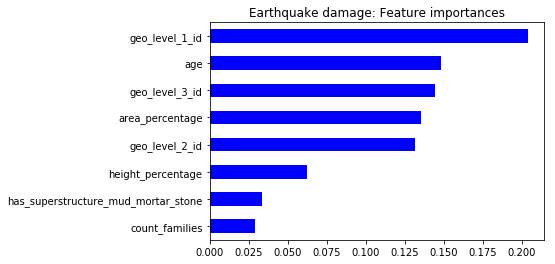

In [388]:
feat_importance = pd.Series(tree.feature_importances_,index=X.columns)
feat_importance.nlargest(8).plot(kind='barh',title='Earthquake damage: Feature importances',colors='b')
plt.gca().invert_yaxis();